# Deeplearning - Anees Ahmad - 2020/03/29

# 8 Introduction to deep learning for computer vision

## 8.2 Training a convnet from scratch on a small dataset

- “few” samples
  - few hundred to a few tens of thousands of images
- cat and dog small dataset
  - 5,000 pictures of cats and dogs 
    - 2,500cats
    - 2,500 dogs
    - 2,000 pictures for training
    - 1,000 for validation
    - 2,000 for testing
- Steps
  - train a small convnet on the 2,000 training samples
    - without any regularization
      - to set a baseline for what can be achieved
      - 70%
    - Data augmentation
      - 80%-85%
    - feature extraction with a pretrained model
      - 97.5%
    - finetuning a pretrained model
      - 98.5%

### 8.2.1 The relevance of deep learning for small-data problems
- isn’t possible to train a convnet to solve a complex problem with just a few tens of samples
- a few hundred can potentially suffice if the model is small and well regularized and the task is simple. 
- convnets learn local, translation-invariant features, they’re highly data-efficient on perceptual problems. 
- Training a convnet from scratch on a very small image
dataset will yield reasonable results
- deep learning models are highly repurposable

### 8.2.2 Downloading the data

#### Downloading a Kaggle dataset in Google Colaboratory

In [2]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# piece of code to download kaggle data directly to colab
# upload kaggle json file on the colab
from google.colab import files
files.upload()
# make kaggle directory
!mkdir ~/.kaggle
# move kaggle file to newly created folder
!cp kaggle.json ~/.kaggle/
# chnage permissions for file created
!chmod 600 ~/.kaggle/kaggle.json
# Downlaod data from kaggle
!kaggle competitions download -c dogs-vs-cats

Saving kaggle.json to kaggle.json
 98% 799M/812M [00:03<00:00, 245MB/s]
100% 812M/812M [00:03<00:00, 269MB/s]


In [4]:
# unzip downloaded data
!unzip -qq dogs-vs-cats.zip
!unzip -qq train.zip

- DataSet
  - 25,000 images of dogs and cats (12,500 from each class)
    - new dataset containing three subsets
      - a training set with 1,000 samples of each class
      - a validation set with 500 samples of each class
      - a test set with 1,000 samples of each class.

In [5]:
# Listing 8.6 Copying images to training, validation, and test directories

# imports
import os, shutil, pathlib

# path to complete data set 
original_dir = pathlib.Path("train")
# path to smaller data set
new_base_dir = pathlib.Path("cats_vs_dogs_small")

# function to get images from complete set and save in subset
def make_subset(subset_name, start_index, end_index):
  # loop over cat and dog category
  for category in ("cat", "dog"):
    # path to new directory
    dir = new_base_dir / subset_name / category
    # make new directories
    os.makedirs(dir)
    # range of files names
    fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
    for fname in fnames:
      # copy files from source to target
      shutil.copyfile(src=original_dir / fname, dst=dir / fname)
 
# call sfor train, validation and test set
make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2500)

- small data set
  - 2,000 training images
  - 1,000 validation images
  - 2,000 test images. 
    - Each split contains the same number of samples from each class
    - this is a balanced binary classification problem, which means classification accuracy will be an appropriate measure of success.


### 8.2.3 Building the model

In [6]:
# Listing 8.7 Instantiating a small convnet for dogs vs. cats classification

# imports
from tensorflow import keras 
from tensorflow.keras import layers
 
# layers

# inputs which are going to be images
# (180,180,3) is the assumed size of the inputs
# need to rescale inputs to said size
inputs = keras.Input(shape=(180, 180, 3))
# rescaling layer as we need the inputs to be in range [0-1]
x = layers.Rescaling(1./255)(inputs)

# Conv and max poling layers
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)

# flatten the inputs as next we are using dense layer
x = layers.Flatten()(x)
# sigmoid activation as the binary classification problem
outputs = layers.Dense(1, activation="sigmoid")(x)

# model defination
model = keras.Model(inputs=inputs, outputs=outputs)

- The depth of the feature maps progressively increases in the model (from 32 to 256), whereas the size of the feature maps decreases (from 180 × 180 to 7 × 7). This is a pattern you’ll see in almost all convnets.

In [7]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                         

In [8]:
# Listing 8.8 Configuring the model for training
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

### 8.2.4 Data preprocessing
- data should be formatted into appropriately preprocessed floating-point tensors before being fed into the model.
  1. Read the picture files.
  2. Decode the JPEG content to RGB grids of pixels.
  3. Convert these into floating-point tensors.
  4. Resize them to a shared size (we’ll use 180 × 180).
  5. Pack them into batches (we’ll use batches of 32 images).

In [9]:
# Listing 8.9 Using image_dataset_from_directory to read images
  # image_dataset_from_directory(directory) will list the subdirectories of directory
  # index the image files in each subdirectory
  # create and return a tf.data.Dataset object 
    # configured to read these files, 
    # shuffle them
    # decode them to tensors
    # resize them to a shared size
    # and pack them into batches.

from tensorflow.keras.utils import image_dataset_from_directory
 
# create datasets
train_dataset = image_dataset_from_directory(
    # path of the directory
    new_base_dir / "train",
    # reshape images to said size
    image_size=(180, 180),
    # batch size / 32 samples per batch
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


- tf.data API to create efficient input pipelines
  - core class is tf.data.Dataset
- Dataset object is an iterator
  - can use it in a for loop
  - will typically return batches of input data and labels
  - can pass a Dataset object directly to the fit() method of a Keras model.
- Dataset methods
  - .shuffle(buffer_size)
    - Shuffles elements within a buffer
  - .prefetch(buffer_size)
    - Prefetches a buffer of elements in GPU memory to achieve better device utilization.
  - .map(callable)
    - Applies an arbitrary transformation to each element of the dataset (the function callable , which expects to take as input a single element yielded by the dataset).
    - The .map() method, in particular, is one that you will use often.

In [10]:
# create a Dataset instance from a NumPy array of random numbers
import numpy as np 
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)
# At first, our dataset just yields single samples:
# it will create 1000 tensors of shape 16
for i, element in enumerate(dataset):
  print(i,element.shape)
  if i >= 2:
    break
# .batch() method to batch the data
# it will batch 20 samples to one
batched_dataset = dataset.batch(20)
for i, element in enumerate(batched_dataset):
  print(i,element.shape)
  if i >= 2:
    break
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
  print(element.shape)
  if i >= 2:
    break

0 (16,)
1 (16,)
2 (16,)
0 (20, 16)
1 (20, 16)
2 (20, 16)
(4, 4)
(4, 4)
(4, 4)


In [11]:
# Listing 8.10 Displaying the shapes of the data and labels yielded by the Dataset
for i, element in enumerate(train_dataset):
  pass
print("bathces of train_dataset : ",i)

for train_data_batch, train_labels_batch in train_dataset:
  print("train data batch shape:", train_data_batch.shape)
  print("train labels batch shape:", train_labels_batch.shape)
  break

for i, element in enumerate(validation_dataset):
  pass
print("bathces of validation_dataset : ",i)
for validation_data_batch, validation_labels_batch in validation_dataset:
  print("validation data batch shape:", validation_data_batch.shape)
  print("validation labels batch shape:", validation_labels_batch.shape)
  break

for i, element in enumerate(test_dataset):
  pass
print("bathces of test_dataset : ",i)
for test_data_batch, test_labels_batch in test_dataset:
  print("test data batch shape:", test_data_batch.shape)
  print("test labels batch shape:", test_labels_batch.shape)
  break

bathces of train_dataset :  62
train data batch shape: (32, 180, 180, 3)
train labels batch shape: (32,)
bathces of validation_dataset :  31
validation data batch shape: (32, 180, 180, 3)
validation labels batch shape: (32,)
bathces of test_dataset :  62
test data batch shape: (32, 180, 180, 3)
test labels batch shape: (32,)


- ModelCheckpoint callback to save the model after each epoch. 
  - configure
    - specifying where to save the file 
    - arguments 
      - save_best_only=True
      - monitor="val_loss"
    - save a new file when the current value of the val_loss metric is lower than at any previous time during training.
  - won’t have to retrain a new model for a lower number of epochs if we start overfitting

In [12]:
# Listing 8.11 Fitting the model using a Dataset
callbacks = [
  keras.callbacks.ModelCheckpoint(
  filepath="cats_vs_dogs_small.keras",
  save_best_only=True,
  monitor="val_loss")
]

history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 19s 81ms/step - loss: 0.7288 - accuracy: 0.4925 - val_loss: 0.6911 - val_accuracy: 0.5910
Epoch 2/30
63/63 [==============================] - 5s 69ms/step - loss: 0.7001 - accuracy: 0.5480 - val_loss: 0.6567 - val_accuracy: 0.6080
Epoch 3/30
63/63 [==============================] - 5s 70ms/step - loss: 0.6900 - accuracy: 0.5850 - val_loss: 0.6305 - val_accuracy: 0.6560
Epoch 4/30
63/63 [==============================] - 5s 69ms/step - loss: 0.6260 - accuracy: 0.6605 - val_loss: 0.5979 - val_accuracy: 0.6780
Epoch 5/30
63/63 [==============================] - 5s 70ms/step - loss: 0.5914 - accuracy: 0.6905 - val_loss: 0.5945 - val_accuracy: 0.6780
Epoch 6/30
63/63 [==============================] - 5s 69ms/step - loss: 0.5681 - accuracy: 0.7070 - val_loss: 0.7577 - val_accuracy: 0.5880
Epoch 7/30
63/63 [==============================] - 5s 69ms/step - loss: 0.5194 - accuracy: 0.7465 - val_loss: 0.6387 - val_accuracy: 0.7080
Epoch 8/30
6

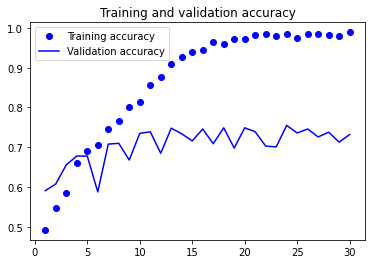

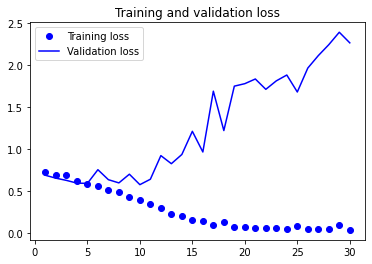

In [13]:
# Listing 8.12 Displaying curves of loss and accuracy during training
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

- overfitting. 
  - The training accuracy increases linearly over time, until it reaches nearly 100%
  - the validation accuracy peaks at 75%
  - The validation loss reaches its minimum after only ten epochs and then stalls
  - training loss keeps decreasing linearly as training proceeds.

In [14]:
# Listing 8.13 Evaluating the model on the test set
# load model, saved before overfitting started
test_model = keras.models.load_model("cats_vs_dogs_small.keras")
test_loss, test_acc = test_model.evaluate(test_dataset) 
print(f"Test accuracy: {test_acc:.3f}")

63/63 [==============================] - 3s 37ms/step - loss: 0.5833 - accuracy: 0.7150
Test accuracy: 0.715


- a test accuracy of 74%

### 8.2.5 Using data augmentation

- Overfitting is caused by having too few samples to learn fro
- infinite data, your model would be exposed to every possible aspect of the data distribution at hand
  - you would never overfit. 
- Data augmentation takes the approach of generating more training data from existing training samples by augmenting the samples via a number of random transformations that yield believable looking images. 
  - The goal is that, at training time, your model will never see the exact same picture twice.

In [15]:
# Listing 8.14 Define a data augmentation stage to add to an image mode
data_augmentation = keras.Sequential(
    [
     layers.RandomFlip("horizontal"),
     layers.RandomRotation(0.1),
     layers.RandomZoom(0.2),
    ]
  )

- RandomFlip("horizontal")
  - Applies horizontal flipping to a random 50% of the images that go through it
- RandomRotation(0.1)
  - Rotates the input images by a random value in the range [–10%, +10%] (these are fractions of a full circle—in degrees, the range would be [–36 degrees, +36 degrees])
- RandomZoom(0.2) —Zooms in or out of the image by a random factor in the range [-20%, +20%]

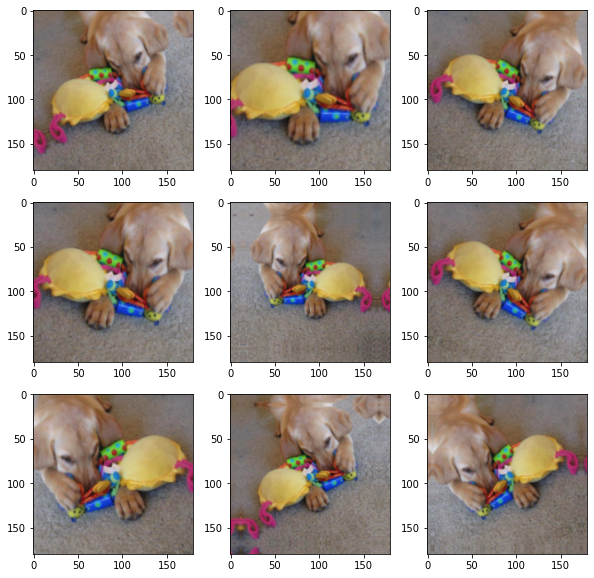

In [18]:
# Listing 8.15 Displaying some randomly augmented training images
plt.figure(figsize=(10, 10)) 
for images, _ in train_dataset.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))

- train a new model using this data-augmentation configuration
  - the model will never see the same input twice. 
  - inputs it sees are still heavily intercorrelated because they come from a small number of original images
    - we can’t produce new information
      - we can only remix existing information. 
  - this may not be enough to completely get rid of overfitting. 
  - To further fight overfitting
    - add a Dropout layer to our model right before the densely connected classifier.

In [21]:
# Listing 8.16 Defining a new convnet that includes image augmentation and dropout
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
 
model.compile(
    loss="binary_crossentropy",
    optimizer="rmsprop",
    metrics=["accuracy"])

In [22]:
# Listing 8.17 Training the regularized convnet
callbacks = [
  keras.callbacks.ModelCheckpoint(
  filepath="cats_vs_dogs_small_with_augmentation.keras",
  save_best_only=True,
  monitor="val_loss")
]
history = model.fit(
  train_dataset,
  epochs=100,
  validation_data=validation_dataset,
  callbacks=callbacks)

Epoch 1/100
63/63 [==============================] - 6s 76ms/step - loss: 0.7186 - accuracy: 0.4925 - val_loss: 0.6929 - val_accuracy: 0.5010
Epoch 2/100
63/63 [==============================] - 5s 73ms/step - loss: 0.6948 - accuracy: 0.5315 - val_loss: 0.6850 - val_accuracy: 0.6260
Epoch 3/100
63/63 [==============================] - 5s 71ms/step - loss: 0.7012 - accuracy: 0.5705 - val_loss: 0.6908 - val_accuracy: 0.5330
Epoch 4/100
63/63 [==============================] - 5s 71ms/step - loss: 0.6757 - accuracy: 0.5915 - val_loss: 0.7528 - val_accuracy: 0.5540
Epoch 5/100
63/63 [==============================] - 5s 71ms/step - loss: 0.6727 - accuracy: 0.6060 - val_loss: 0.7346 - val_accuracy: 0.5820
Epoch 6/100
63/63 [==============================] - 5s 72ms/step - loss: 0.6346 - accuracy: 0.6505 - val_loss: 0.6475 - val_accuracy: 0.6330
Epoch 7/100
63/63 [==============================] - 5s 73ms/step - loss: 0.6260 - accuracy: 0.6555 - val_loss: 0.6054 - val_accuracy: 0.6530
Epoch 

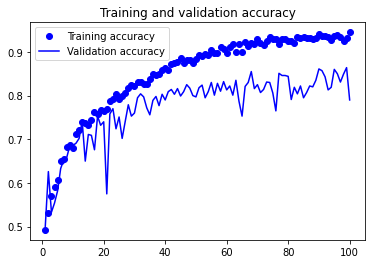

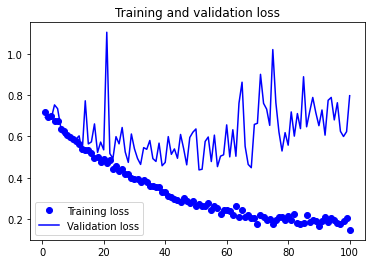

In [23]:
# Displaying curves of loss and accuracy during training
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [24]:
# Listing 8.18 Evaluating the model on the test set
test_model = keras.models.load_model("cats_vs_dogs_small_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")


63/63 [==============================] - 3s 36ms/step - loss: 0.5145 - accuracy: 0.8215
Test accuracy: 0.822


- a test accuracy of 82%